# Instruments I2I 实验笔记本

此笔记本实现：
- 加载原始 / 增强的 item 数据与图片路径
- 计算基于交互历史的共现 ground-truth（每个 item 的最常共现 item）
- 尝试加载已有的预计算表征（来自 `data/Instruments/*_rep.npy` 或 `*_rep.json`），或者调用 `data_process/qwen_embeddings.py` 进行提取（在 GPU 上耗时且会加载模型）
- 基于表征做最近邻检索并计算 Hit@1/5/10
- 保存与可视化结果

说明：笔记本包含两条路径 —— 推荐先使用已有的预计算表征文件（如果存在），否则按需运行模型提取（耗时并需要可用的 GPU/依赖）。

In [1]:
# 1. 导入依赖
import os
import json
from pathlib import Path
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 可视化设置（可选）
%matplotlib inline

In [2]:
# 2. 配置路径
ROOT = Path("../data")
DATASET = "Instruments"
dataset_dir = ROOT / DATASET
print("dataset_dir =", dataset_dir)

item_json_path = dataset_dir / f"{DATASET}.item.json"
item_enriched_path = dataset_dir / f"{DATASET}.item_enriched_v2.json"
item2id_path = dataset_dir / f"{DATASET}.item2id"
inter_path = dataset_dir / f"{DATASET}.inter.json"
image_dir = dataset_dir / "images"

for p in [
    item_json_path,
    item_enriched_path,
    item2id_path,
    inter_path,
    image_dir,
]:
    print(p.exists(), p)

dataset_dir = ../data/Instruments
True ../data/Instruments/Instruments.item.json
True ../data/Instruments/Instruments.item_enriched_v2.json
True ../data/Instruments/Instruments.item2id
True ../data/Instruments/Instruments.inter.json
True ../data/Instruments/images


In [3]:
# 3. 加载映射与 item 信息的辅助函数
def load_item2id(path):
    item2id = {}
    id2item = {}
    with open(path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            item_id, num_id = line.strip().split("	")
            item2id[item_id] = int(num_id)
            id2item[int(num_id)] = item_id
    return item2id, id2item


def load_json(path):
    with open(path, "r") as f:
        return json.load(f)


# 尝试加载文件（存在性已在上一步打印）
if item2id_path.exists():
    item2id, id2item = load_item2id(item2id_path)
else:
    item2id, id2item = {}, {}

item_info = load_json(item_json_path) if item_json_path.exists() else {}
item_enriched = (
    load_json(item_enriched_path) if item_enriched_path.exists() else {}
)
inter = load_json(inter_path) if inter_path.exists() else {}

print("n_items (orig)=", len(item_info))
print("n_items (enriched)=", len(item_enriched))
print("n_inter keys =", len(inter))

n_items (orig)= 6250
n_items (enriched)= 6250
n_inter keys = 17112


In [4]:
# 4. 构建 co-occurrence ground-truth（每个 item 的 most co-occurred item）
# inter 的格式示例： key -> [list of item numeric ids happened in a session]


def build_cooccurrence(inter):
    # 统计共现次数（对无向共现计数）
    co = defaultdict(Counter)
    for key, seq in inter.items():
        # 保护类型
        if not isinstance(seq, list):
            continue
        for i in range(len(seq)):
            a = int(seq[i])
            for j in range(i + 1, len(seq)):
                b = int(seq[j])
                if a == b:
                    continue
                co[a][b] += 1
                co[b][a] += 1
    # 为每个 item 找出共现次数最高的 item（排除自身）
    ground_truth = {}
    for a, counter in co.items():
        if len(counter) == 0:
            continue
        most_common_b, _ = counter.most_common(1)[0]
        ground_truth[a] = most_common_b
    return ground_truth, co


ground_truth, co = build_cooccurrence(inter)
print("ground-truth labels for", len(ground_truth), "items")

# 查看若干示例
for k in list(ground_truth.keys())[:10]:
    print(k, "->", ground_truth[k])

ground-truth labels for 6250 items
0 -> 29
1 -> 624
2 -> 2217
3 -> 0
4 -> 2765
5 -> 6
6 -> 141
7 -> 92
8 -> 1056
9 -> 13


如果你已经有由 `data_process/qwen_embeddings.py` 生成的表征文件（例如 `data/Instruments/Qwen/Qwen2.5-VL-7B-Instruct_rep.npy` 或 `*_rep.json/_rep.npy`），建议直接加载它们以节省时间。下面提供加载预计算表征与调用提取器的示例。

In [5]:
# 5. 加载预计算表征的工具函数（优先使用）
def load_precomputed_rep_json(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
    # d: {num_id: { 'representation': [...], 'item_id':.. }}
    keys = sorted(int(k) for k in d.keys())
    print(keys)
    reps = np.array([d[k]["representation"] for k in keys])
    return keys, reps, d


def find_precomputed(dataset_dir, prefix_contains=None):
    candidates = list(dataset_dir.glob("*_rep.npy")) + list(
        dataset_dir.glob("*_rep.json")
    )
    if prefix_contains:
        candidates = [p for p in candidates if prefix_contains in str(p)]
    return candidates


cands = find_precomputed(dataset_dir)
print("found precomputed rep files:", cands)

found precomputed rep files: [PosixPath('../data/Instruments/VLM2Vec_rep.npy')]


In [6]:
# 7. 检索评估函数（nearest neighbor + Hit@K）
def evaluate_hitk(
    query_embs, corpus_embs, gt_for_query_index, ks=(1, 5, 10), metric="cosine"
):
    # 使用 sklearn NearestNeighbors，用 cosine 距离（即 1-cos）或 euclidean
    if metric == "cosine":
        nn = NearestNeighbors(n_neighbors=max(ks) + 1, metric="cosine")
    else:
        nn = NearestNeighbors(n_neighbors=max(ks) + 1, metric=metric)

    nn.fit(corpus_embs)
    distances, indices = nn.kneighbors(query_embs, return_distance=True)
    results = {}
    n = query_embs.shape[0]
    for k in ks:
        hits = 0
        for i in range(n):
            # indices[i] 包含 query 自身（如果 corpus == queries）
            retrieved = list(indices[i])
            # 如果 corpus 和 query 是同一集合，去掉自身（第一个匹配）
            if retrieved and retrieved[0] == i:
                retrieved = retrieved[1 : k + 1]
            else:
                retrieved = retrieved[:k]
            gt = gt_for_query_index.get(i, None)
            if gt is None:
                continue
            if gt in retrieved:
                hits += 1
        results[f"Hit@{k}"] = hits / float(n)
    return results, distances, indices


print("Evaluation helper ready")

Evaluation helper ready


In [7]:
# 8. 将 ground_truth 映射为索引（当我们使用按 num_id 排序的 embedding 矩阵时）
# 假设我们有一个 keys 列表，对应 embedding 矩阵的行索引（keys[i] -> num_id）
def build_gt_index_map(keys, ground_truth):
    # keys: list of num_id in order matching embedding matrix rows
    numid_to_row = {num_id: idx for idx, num_id in enumerate(keys)}
    gt_index = {}
    for row_idx, num_id in enumerate(keys):
        gt_num = ground_truth.get(num_id, None)
        if gt_num is None:
            continue
        gt_row = numid_to_row.get(gt_num, None)
        if gt_row is None:
            continue
        gt_index[row_idx] = gt_row
    return gt_index


print("GT index builder ready")

GT index builder ready


In [8]:
reps_dir = dataset_dir / "Qwen"
candidates = find_precomputed(reps_dir)
print(reps_dir)
print(candidates)

../data/Instruments/Qwen
[PosixPath('../data/Instruments/Qwen/Qwen2.5-VL-3B-Instruct_rep.npy'), PosixPath('../data/Instruments/Qwen/Qwen2.5-VL-7B-Instruct_rep.npy'), PosixPath('../data/Instruments/Qwen/Qwen2.5-VL-7B-Instruct_rep.json'), PosixPath('../data/Instruments/Qwen/Qwen2.5-VL-3B-Instruct_rep.json')]


In [ ]:
# 10. 加载三套预计算表征并评估（orig, orig_enhanced, enhanced）
modes = ["orig", "orig_enhanced", "enhanced"]
reps_dir = dataset_dir / "reps"
models = ["Qwen2.5-VL-7B-Instruct", "Qwen2-VL-7B-Instruct"]
available = {}
for m in modes:
    for model in models:
        candidates = []
        if reps_dir.exists():
            candidates = [_ for _ in reps_dir.glob(f"{model}_{m}.npy")]
        if not candidates:
            print(f"No precomputed files found for mode={m} in", reps_dir)
            continue
        chosen = candidates[0]
        print("Loading", chosen)
        if str(chosen).endswith(".json"):
            keys, reps, raw = load_precomputed_rep_json(chosen)
        else:
            arr = np.load(chosen)
            reps = arr
            keys = list(range(reps.shape[0]))
        available[f"{model}_{m}"] = {"path": chosen, "keys": keys, "reps": reps}

# 将 dataset 根目录下的 external embeddings (llama_ts / vit_l14) 加入 available，以便后续统一评估/绘图
for name, fname in [
    ("llama_td", f"{DATASET}.emb-llama-td.npy"),
    ("vit_l14", f"{DATASET}.emb-ViT-L-14.npy"),
]:
    p = dataset_dir / fname
    if p.exists():
        arr = np.load(p)
        keys = list(range(arr.shape[0]))
        available[name] = {"path": p, "keys": keys, "reps": arr}
        print("Added external embedding to available:", name, p, arr.shape)
    else:
        print("External embedding not found:", p)

print("available keys now:", list(available.keys()))

Loading ../data/Instruments/reps/Qwen2.5-VL-7B-Instruct_orig.npy
Loading ../data/Instruments/reps/Qwen2-VL-7B-Instruct_orig.npy
Loading ../data/Instruments/reps/Qwen2.5-VL-7B-Instruct_orig_enhanced.npy
Loading ../data/Instruments/reps/Qwen2-VL-7B-Instruct_orig_enhanced.npy
Loading ../data/Instruments/reps/Qwen2.5-VL-7B-Instruct_enhanced.npy
Loading ../data/Instruments/reps/Qwen2-VL-7B-Instruct_enhanced.npy
Loaded modes: ['Qwen2.5-VL-7B-Instruct_orig', 'Qwen2-VL-7B-Instruct_orig', 'Qwen2.5-VL-7B-Instruct_orig_enhanced', 'Qwen2-VL-7B-Instruct_orig_enhanced', 'Qwen2.5-VL-7B-Instruct_enhanced', 'Qwen2-VL-7B-Instruct_enhanced']


In [37]:
# load *.json.texts.txt for all the text check
for m in modes:
    # ensure exact suffix match for texts file as well
    # ensure exact match for texts file by stripping the known suffix and comparing trailing tokens
    m_tokens = m.split("_")
    cand = [_ for _ in reps_dir.glob(f"{model}_{m}.json.texts.txt")]
    print(cand)
    if not cand:
        print("No texts file for mode", m)
        continue
    with open(cand[0], "r") as f:
        texts = [line.strip() for line in f]
    available[m]["texts"] = texts
    for _ in texts:
        print(_)

[PosixPath('../data/Instruments/reps/Qwen2.5-VL-7B-Instruct_orig.json.texts.txt')]
mode: orig
num_id=0 item_id=B002SQJL9U has_image=True
Title: Blue Microphones enCORE 100 Studio-Grade Dynamic Performance Microphone. | Brand: Blue Microphones | Categories: Musical Instruments,Microphones & Accessories,Microphones,Dynamic Microphones,Multipurpose
---
num_id=1 item_id=B00D3QFHN8 has_image=True
Title: HDE USB to MIDI Interface Cable Keyboard Synthesizer Drum Pad Instrument MIDI 5 Pin Adapter for Windows PCs. | Brand: HDE | Categories: Musical Instruments,Live Sound & Stage,Stage & Studio Cables,MIDI Cables | Description:  USB to MIDI Interface is a complete solution for hooking up MIDI enabled keyboards, drum pads, mixers, synthesizers and other instruments to your Windows PC. Plug and Play device makes it easy to get started in home audio production, whether you are recording audio, remixing, creating chiptunes or doing your own podcast. Device is compatible only with 32 bit Windows vers

In [13]:
for keys in available:
    print(keys)
    print(available[keys]["keys"][:10])
    print("First reps 0~10:")
    print(available[keys]["reps"][0][:10])
    print("-" * 50)

Qwen2.5-VL-7B-Instruct_orig
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
First reps 0~10:
[ 1.97134638  0.3080861   0.27581155 -0.26476142 -0.21454464  0.27580443
 -0.32257545 -0.18600309  0.49550772  0.8877061 ]
--------------------------------------------------
Qwen2-VL-7B-Instruct_orig
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
First reps 0~10:
[-0.84376317 -0.69007069 -0.74914569  1.89048779 -0.43333617  1.36311865
 -0.16407304 -1.70396423 -0.06985226  0.86184055]
--------------------------------------------------
Qwen2.5-VL-7B-Instruct_orig_enhanced
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
First reps 0~10:
[ 2.16225576  0.51975948  0.73316276 -0.79717404  0.12815039  0.45709547
 -0.40658906  0.02223146  0.62550682  1.07282841]
--------------------------------------------------
Qwen2-VL-7B-Instruct_orig_enhanced
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
First reps 0~10:
[-0.732916   -0.57148778 -0.4427729   1.89094651 -0.40644506  1.12387693
 -0.09293985 -1.8627156   0.26931852  0.35297111]
-------------------------------------

In [14]:
# 11. 为每个模式计算 Hit@1/5/10/50，并记录检索排名分布（不运行模型提取）
eval_results = {}
rank_info = {}
ks = (1, 5, 10, 50)
for m, info in available.items():
    reps = info["reps"]
    keys = info["keys"]
    gt_idx = build_gt_index_map(keys, ground_truth)
    if len(gt_idx) == 0:
        print(f"No ground-truth mapping available for mode {m}, skipping")
        continue
    # request neighbors up to max(ks)+1 (to account for self)
    results, dists, inds = evaluate_hitk(
        reps, reps, gt_idx, ks=ks, metric="cosine"
    )
    eval_results[m] = results
    # compute rank of gt for each query given returned indices (use up to ks max)
    ranks = []
    max_neigh = max(ks) + 1
    # if evaluate_hitk returned fewer neighbors, pad handling will follow
    for i in range(len(reps)):
        gt = gt_idx.get(i, None)
        if gt is None:
            continue
        retrieved = list(inds[i])
        if retrieved and retrieved[0] == i:
            retrieved = retrieved[1:]
        try:
            r = retrieved.index(gt) + 1
        except ValueError:
            r = None
        ranks.append(r)
    rank_info[m] = ranks
    print(f"Finished eval for mode={m}:", results)

Finished eval for mode=Qwen2.5-VL-7B-Instruct_orig: {'Hit@1': 0.02576, 'Hit@5': 0.05264, 'Hit@10': 0.06768, 'Hit@50': 0.11632}
Finished eval for mode=Qwen2-VL-7B-Instruct_orig: {'Hit@1': 0.032, 'Hit@5': 0.06352, 'Hit@10': 0.08096, 'Hit@50': 0.14544}
Finished eval for mode=Qwen2.5-VL-7B-Instruct_orig_enhanced: {'Hit@1': 0.02864, 'Hit@5': 0.05728, 'Hit@10': 0.07296, 'Hit@50': 0.12352}
Finished eval for mode=Qwen2-VL-7B-Instruct_orig_enhanced: {'Hit@1': 0.03184, 'Hit@5': 0.06656, 'Hit@10': 0.08448, 'Hit@50': 0.15456}
Finished eval for mode=Qwen2.5-VL-7B-Instruct_enhanced: {'Hit@1': 0.02944, 'Hit@5': 0.06032, 'Hit@10': 0.07648, 'Hit@50': 0.13104}
Finished eval for mode=Qwen2-VL-7B-Instruct_enhanced: {'Hit@1': 0.0352, 'Hit@5': 0.06768, 'Hit@10': 0.08672, 'Hit@50': 0.15904}
Finished eval for mode=llama_td: {'Hit@1': 0.03248, 'Hit@5': 0.06096, 'Hit@10': 0.08048, 'Hit@50': 0.1328}
Finished eval for mode=vit_l14: {'Hit@1': 0.0264, 'Hit@5': 0.0504, 'Hit@10': 0.06272, 'Hit@50': 0.10672}


Saved comparison eval to notebook/results/modes_compare_eval.json


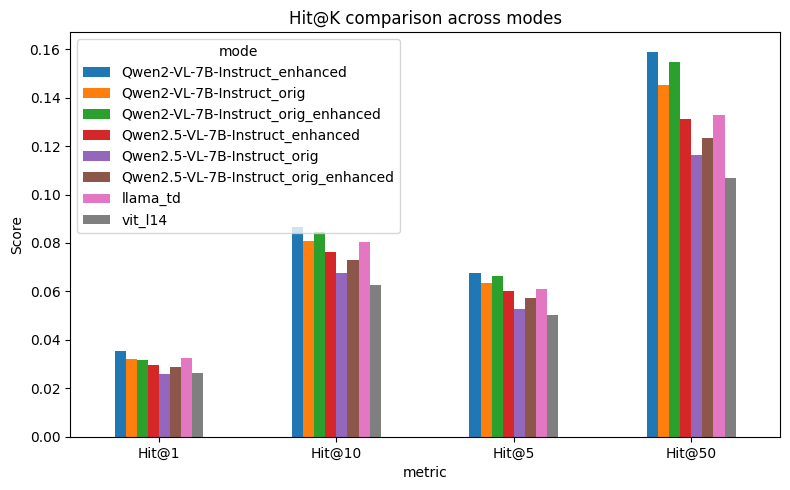

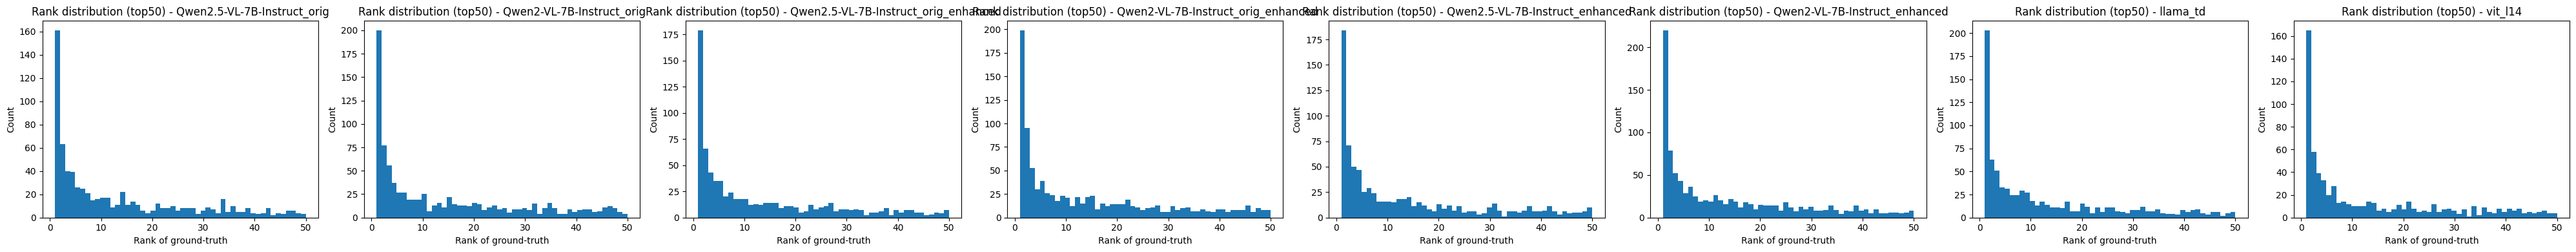

In [ ]:
# 12. 保存对比结果并绘图 (改进：固定 Hit@K 顺序，按 mode 排序，并新增曲线图)
out_dir = Path("notebook/results")
out_dir.mkdir(parents=True, exist_ok=True)
cmp_path = out_dir / "modes_compare_eval.json"
with open(cmp_path, "w") as f:
    json.dump({"eval": eval_results}, f, indent=2)
print("Saved comparison eval to", cmp_path)

# 可视化：Hit@K 对比柱状图（确保 x 轴顺序为 Hit@1, Hit@5, Hit@10, Hit@50），并按 mode 总体得分降序排序
import pandas as pd

# 将 eval_results 展平成表格
df_rows = []
for m, res in eval_results.items():
    for k, v in res.items():
        df_rows.append({"mode": m, "metric": k, "value": v})
df = pd.DataFrame(df_rows)

# 指定我们希望的 metric 顺序
ordered_metrics = ["Hit@1", "Hit@5", "Hit@10", "Hit@50"]
# 仅保留这几项用于排序与绘图（若某些 mode 缺失某项会以 NaN 表示）
df_plot = df[df.metric.isin(ordered_metrics)].copy()
# 计算每个 mode 的总体分数（这里使用简单平均）
overall_scores = df_plot.groupby("mode")["value"].mean()
mode_order = overall_scores.sort_values(ascending=False).index.tolist()
print("Mode order (best->worst):", mode_order)

# 生成有序 pivot 表（按 metric 固定顺序与 mode 排序）
pivot = df_plot.pivot(index="metric", columns="mode", values="value").reindex(
    ordered_metrics
)
# 如果某些 mode 未出现在 pivot 中，确保列包含所有 mode_order（缺失值保持 NaN）
for m in mode_order:
    if m not in pivot.columns:
        pivot[m] = np.nan
pivot = pivot[mode_order]

# 绘制分组柱状图（按 mode_order 列顺序）
fig_bar, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind="bar", ax=ax, rot=0)
ax.set_ylabel("Score")
ax.set_title("Hit@K comparison across modes (ordered by overall score)")
ax.set_xticklabels(ordered_metrics)
ax.legend(title="mode", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# 保存柱状图
bar_path = out_dir / "hitk_comparison_bar.png"
fig_bar.savefig(bar_path, dpi=200)
print("Saved bar chart to", bar_path)
plt.show()

# 曲线图：Hit@K 随 K 的变化（按 mode_order，从高到低绘制）
ks_numeric = [1, 5, 10, 50]
fig_line, ax = plt.subplots(figsize=(10, 6))
metric_to_k = {
    m: int(m.split("@")[1]) if "@" in m else i
    for i, m in enumerate(ordered_metrics, start=1)
}
# 为每个 mode 构建 y 序列（顺序对应 ordered_metrics）
for m in mode_order:
    y = []
    for met in ordered_metrics:
        try:
            val = float(pivot.loc[met, m])
        except Exception:
            val = np.nan
        y.append(val)
    ax.plot(ks_numeric, y, marker="o", label=m)
ax.set_xticks(ks_numeric)
ax.set_xticklabels(ordered_metrics)
ax.set_xlabel("Metric (Hit@K)")
ax.set_ylabel("Score")
ax.set_title("Hit@K curve (modes ordered by overall score)")
ax.legend(title="mode", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y")
plt.tight_layout()
# 保存曲线图
line_path = out_dir / "hitk_curve.png"
fig_line.savefig(line_path, dpi=200)
print("Saved line chart to", line_path)
plt.show()

# 可视化：检索排名分布（仅显示前50），并保存图片
fig, axes = plt.subplots(1, len(rank_info), figsize=(5 * len(rank_info), 4))
if len(rank_info) == 1:
    axes = [axes]
for ax, (m, ranks) in zip(axes, rank_info.items()):
    ranks_clean = [r for r in ranks if r is not None and r <= 50]
    ax.hist(ranks_clean, bins=50, range=(1, 50))
    ax.set_title(f"Rank distribution (top50) - {m}")
    ax.set_xlabel("Rank of ground-truth")
    ax.set_ylabel("Count")
plt.tight_layout()
rank_path = out_dir / "rank_distributions.png"
fig.savefig(rank_path, dpi=200)
print("Saved rank distribution to", rank_path)
plt.show()

# 也把排序后的评估表写成 CSV / JSON 以便外部查看
summary_df = df_plot.pivot(
    index="mode", columns="metric", values="value"
).reindex(mode_order)
summary_csv = out_dir / "modes_compare_eval_sorted.csv"
summary_df.to_csv(summary_csv)
print("Saved sorted summary to", summary_csv)
summary_json = out_dir / "modes_compare_eval_sorted.json"
# pandas.fillna(None) raises ValueError in recent pandas versions.
# Use where to replace NaN with None so JSON will contain nulls safely.
summary_df.where(pd.notnull(summary_df), None).to_json(
    summary_json, orient="index", indent=2
)
print("Saved sorted summary json to", summary_json)

In [ ]:
# 13. 按 model 与按 mode 的可视化（含 img / noimg 变体）
import re
import pandas as pd


# 解析 key，支持末尾带 img/noimg 的命名，也支持没有 img 标记的情况
def _parse_key(key):
    # examples: 'Qwen2.5-VL-7B-Instruct_orig_img', 'Qwen2-VL-7B-Instruct_enhanced_noimg', 'llama_td_orig'
    parts = str(key).split("_")
    img_flag = "img"
    mode_tag = ""
    model = key
    if parts[-1] in ("img", "noimg"):
        img_flag = parts[-1]
        if len(parts) >= 2:
            mode_tag = parts[-2]
            model = "_".join(parts[:-2]) if len(parts) > 2 else parts[0]
    else:
        mode_tag = parts[-1] if len(parts) >= 2 else ""
        model = "_".join(parts[:-1]) if len(parts) >= 2 else parts[0]
    if mode_tag in ("image_only", "only_image"):
        mode_tag = "only_image"
    return model, mode_tag, img_flag


# build df2 with parsed columns
df2 = df.copy()
parsed = df2["mode"].apply(lambda s: pd.Series(_parse_key(s)))
parsed.columns = ["model", "mode_tag", "img_flag"]
df2 = pd.concat([df2, parsed], axis=1)

ordered_metrics = ["Hit@1", "Hit@5", "Hit@10", "Hit@50"]
target_modes = ["orig", "orig_enhanced", "enhanced", "only_image"]

# 1) 对于四个主要 mode（orig, orig_enhanced, enhanced, only_image），比较所有模型在 img / noimg 下的表现
for mode_tag in target_modes:
    sub = df2[df2["mode_tag"] == mode_tag].copy()
    if sub.empty:
        print("No data for mode", mode_tag)
        continue
    sub["model_label"] = sub["model"] + " (" + sub["img_flag"] + ")"
    pivot = sub.pivot(
        index="metric", columns="model_label", values="value"
    ).reindex(ordered_metrics)
    # 按平均分排序列顺序（从高到低）
    col_order = pivot.mean().sort_values(ascending=False).index.tolist()
    pivot = pivot[col_order]
    # bar plot
    fig, ax = plt.subplots(figsize=(12, max(4, len(col_order) * 0.5)))
    pivot.plot(kind="bar", ax=ax, rot=0)
    ax.set_title(f"[{mode_tag}] Hit@K across models (img/noimg)")
    ax.set_ylabel("Score")
    ax.set_xticklabels(ordered_metrics)
    ax.legend(
        title="model (img_flag)", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.tight_layout()
    fname = out_dir / f"mode_{mode_tag}_models_img_noimg_bar.png"
    fig.savefig(fname, dpi=200)
    print("Saved", fname)
    plt.show()
    # line plot (Hit@K curve)
    fig, ax = plt.subplots(figsize=(12, max(4, len(col_order) * 0.5)))
    ks_numeric = [1, 5, 10, 50]
    for col in pivot.columns:
        y = [
            pivot.loc[m, col] if col in pivot.columns else np.nan
            for m in ordered_metrics
        ]
        ax.plot(ks_numeric, y, marker="o", label=col)
    ax.set_xticks(ks_numeric)
    ax.set_xticklabels(ordered_metrics)
    ax.set_xlabel("Metric (Hit@K)")
    ax.set_ylabel("Score")
    ax.set_title(f"[{mode_tag}] Hit@K curve across models (img/noimg)")
    ax.legend(
        title="model (img_flag)", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.grid(axis="y")
    plt.tight_layout()
    fname = out_dir / f"mode_{mode_tag}_models_img_noimg_curve.png"
    fig.savefig(fname, dpi=200)
    print("Saved", fname)
    plt.show()

# 2) 对于每个 model，比较其下的 orig/orig_enhanced/enhanced/only_image × img/noimg 的排序和曲线
for model_name in sorted(df2["model"].dropna().unique()):
    sub = df2[df2["model"] == model_name].copy()
    if sub.empty:
        continue
    sub["mode_label"] = sub["mode_tag"] + "_" + sub["img_flag"]
    pivot = sub.pivot(
        index="metric", columns="mode_label", values="value"
    ).reindex(ordered_metrics)
    col_order = pivot.mean().sort_values(ascending=False).index.tolist()
    pivot = pivot[col_order]
    # bar plot
    fig, ax = plt.subplots(figsize=(10, max(4, len(col_order) * 0.5)))
    pivot.plot(kind="bar", ax=ax, rot=0)
    ax.set_title(f"{model_name} - Hit@K across modes (mode_imgflag)")
    ax.set_ylabel("Score")
    ax.set_xticklabels(ordered_metrics)
    ax.legend(title="mode_label", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    safe_model = re.sub(r"[^0-9A-Za-z._-]", "_", model_name)
    fname = out_dir / f"model_{safe_model}_modes_bar.png"
    fig.savefig(fname, dpi=200)
    print("Saved", fname)
    plt.show()
    # line plot
    fig, ax = plt.subplots(figsize=(10, max(4, len(col_order) * 0.5)))
    ks_numeric = [1, 5, 10, 50]
    for col in pivot.columns:
        y = [
            pivot.loc[m, col] if col in pivot.columns else np.nan
            for m in ordered_metrics
        ]
        ax.plot(ks_numeric, y, marker="o", label=col)
    ax.set_xticks(ks_numeric)
    ax.set_xticklabels(ordered_metrics)
    ax.set_xlabel("Metric (Hit@K)")
    ax.set_ylabel("Score")
    ax.set_title(f"{model_name} - Hit@K curve across modes (mode_imgflag)")
    ax.legend(title="mode_label", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y")
    plt.tight_layout()
    fname = out_dir / f"model_{safe_model}_modes_curve.png"
    fig.savefig(fname, dpi=200)
    print("Saved", fname)
    plt.show()

## 下一步（建议)

- 如果没有预计算表征且你有资源：在终端运行 `python data_process/qwen_embeddings.py --dataset Instruments --model <model-name>` 生成表征（会输出 json + npy）。
- 为实现三种方案（原文+图像、原文+增强+图像、增强+图像）建议在生成表征时调整 `construct_item_text` 的逻辑或保存三套文本-embedding 对应的文件（例如在调用 `extract_all_items` 前修改 item_info 中的字段并生成三套输出文件）。
- 如果需要，我可以把笔记本扩展为：自动生成这三套输入并依次调用提取器（会在本仓库内创建三份较大的 .npy 文件），并最终输出比较表格与图表。